# Introduction
In this study we wish to show that the semi-analytical model HOPE (Lee et. al., 1999) is suitable to for modelling complex water 

#AIM

Confirm that forward modelling of HOPE parameters agree with Planarrad forward modelling parameters

## Method

The sub-surface remote sensing reflectance was first modelled using Planarrad for a varing few water types.

###Viewing geometry

Sun zenith angle (SZA) 45.28 deg  
Sun azimuth (SAA) 262.39 deg  

###IOPs

The following IOPs were considered and modelled as outlined below

#### Absorption
Absorption due to pure water - $a_{water}(\lambda)$ - Smith & Baker (date)    
Absoprtion due to disolved organic matter - $a_{cdom}(\lambda) - G \exp^{(-S(\lambda - 400))}$    
Absorption due to phytoplankton - $a_\phi(\lambda)$  
Total absorption - $a(\lambda)$ =  $a_{water}(\lambda) + a_{cdom}(\lambda) + a_{\phi}(\lambda)$

#### Back-scattering
Back-scattering due to particles - $b_{bp} = X(\frac{550}{\lambda})^Y$

#### Scattering
Scattering due to pure water - $b_{water}$ - Pope & Fry (date)  
Scattering due to particles - $b_p = \frac{b_{bp}}{{0.02}}$  
Total scattering - $b = b_{water} + b_p$

#### Attenuation
c = a + b

#### Where:

H is depth in meters    
P is phytoplankton scaling parameter $P\times a_\phi$  
G, S are the CDOM scaling parameters $G \exp^{(-S(\lambda - 400))}$  
X, Y are the Particle scaling parameters $X(\frac{550}{\lambda})^Y$  

#### Planarrad requires b & c

$a = a_{water} + a_{cdom} + a_\phi$  
$b_b = b_{bp}$  
$b = \frac{b_bp}{0.02} + b_{water}$  
$c = a + b$

## Run Parameters
The IOPs were varied by making all combinations of IOPs using the following parameter

H = 1, 15, 50  
P = 0.01, 0.05, 0.1  
G = 0.01, 0.05, 0.1  
X = 0.001, 0.01  
Y = 1.0  
S = 0.015  






## The following batch file was created

In [ ]:
# %load /home/marrabld/Projects/hope_test_planarradpy/inputs/batch_files/hope_test_batch.txt
#----------------------------------------#
# Give the batch run a name
#----------------------------------------#
batch_name = hope_test

#----------------------------------------#
# Set the Bio-optical parameters list 
#----------------------------------------#
saa_list = 262.39
sza_list = 45.28
p_list = 0.01, 0.05, 0.1
x_list = 0.001, 0.01
y_list = 1.0
g_list = 0.01, 0.05, 0.1
s_list = 0.015
z_list = 1, 15, 50

#----------------------------------------#
# Wavelengths must be defined
# All IOPs are interpolated to these 
# Wavelengths
#----------------------------------------#
wavelengths = 410.0, 430.0, 450.0, 470.0, 490.0, 510.0, 530.0, 550.0, 570.0, 590.0, 610.0, 630.0, 650.0, 670.0, 690.0, 710.0, 730.0

#----------------------------------------#
# Choose the number of CPUs
# -1 means query the number of CPUs
#----------------------------------------#
num_cpus = 2

#----------------------------------------#
# Set the path of Planarrad
#----------------------------------------#
exec_path = /home/marrabld/Apps/jude2_install/bin

#----------------------------------------#
# Set the logging level
#----------------------------------------#
verbose = 1

#----------------------------------------#
# Set the file paths
# Use absolute paths
#----------------------------------------#
phytoplankton_absorption_file = /home/marrabld/Projects/hope_test_planarradpy/inputs/iop_files/a_phi.csv
bottom_reflectance_file = /home/marrabld/Projects/hope_test_planarradpy/inputs/bottom_files/Refl_BenthicMixture_1_17Bands.txt

#--------------------------------------------------#
# Set the parameter to report
#--------------------------------------------------#
#report_parameter = Rrs

report_parameter = rrs


## Inputs
###Phytoplankton Absoprtion

Populating the interactive namespace from numpy and matplotlib


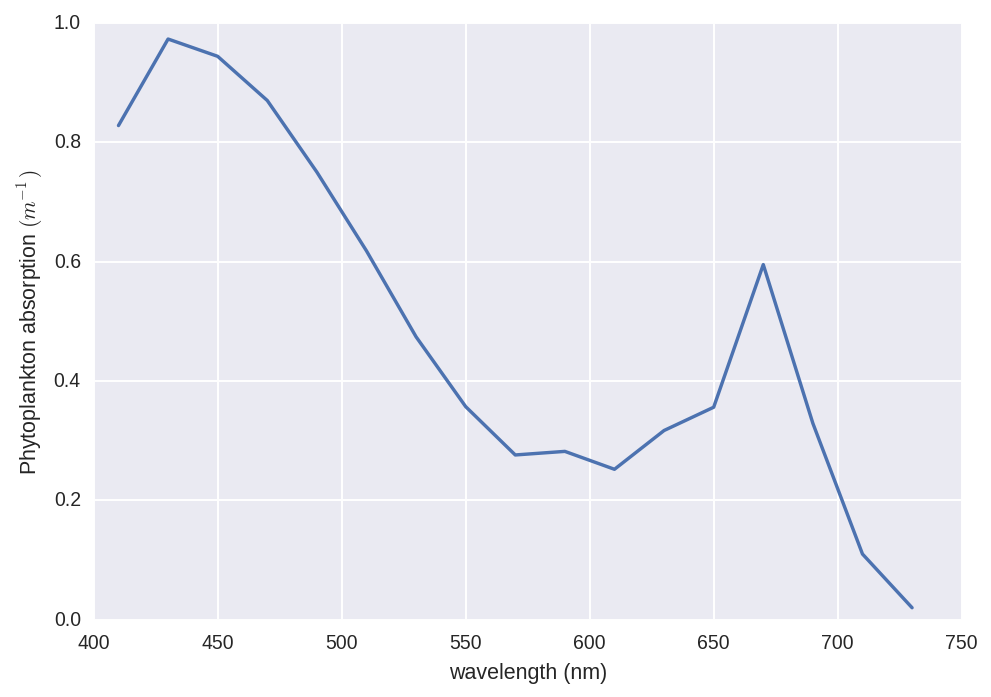

In [1]:
%pylab inline
matplotlib.rcParams['savefig.dpi'] = 140
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np

a_phi = np.genfromtxt('/home/marrabld/Projects/hope_test_planarradpy/inputs/iop_files/a_phi.csv', delimiter=',');
wavelength = a_phi[0,:]
plot(wavelength, a_phi[1,:]);
xlabel('wavelength (nm)');
ylabel('Phytoplankton absorption $(m^{-1})$');

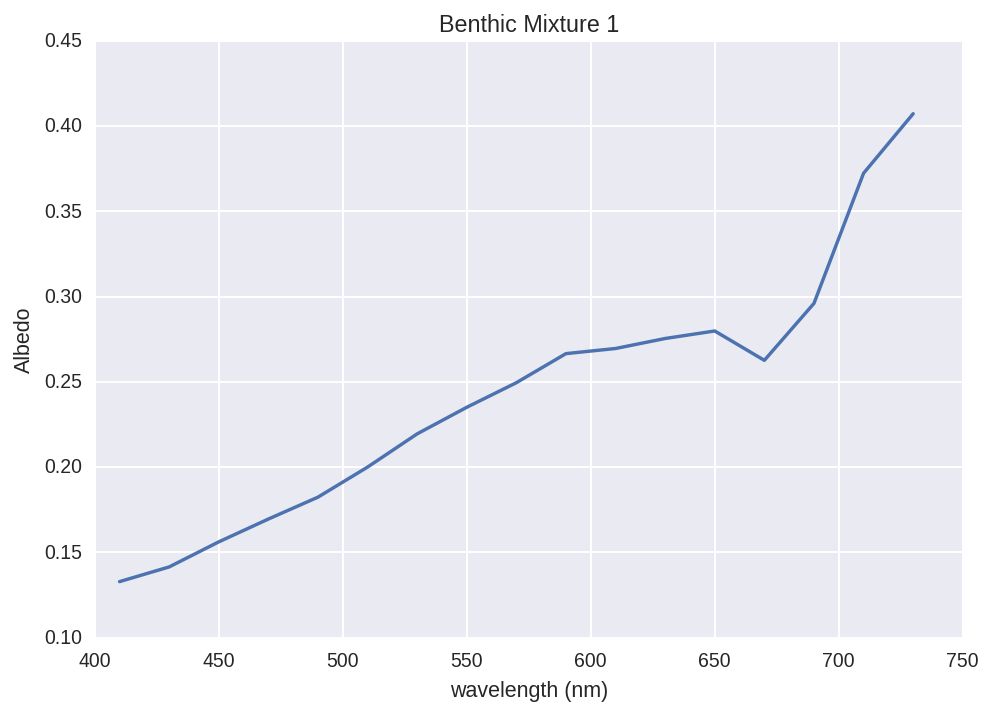

In [2]:
benth = np.genfromtxt('/home/marrabld/Projects/hope_test_planarradpy/inputs/bottom_files/Refl_BenthicMixture_1_17Bands.txt', delimiter=',');

plot(wavelength, benth[:]);
xlabel('wavelength (nm)');
ylabel('Albedo');
title('Benthic Mixture 1');

Now we plot the $R_{rs}$ from Plannarrad

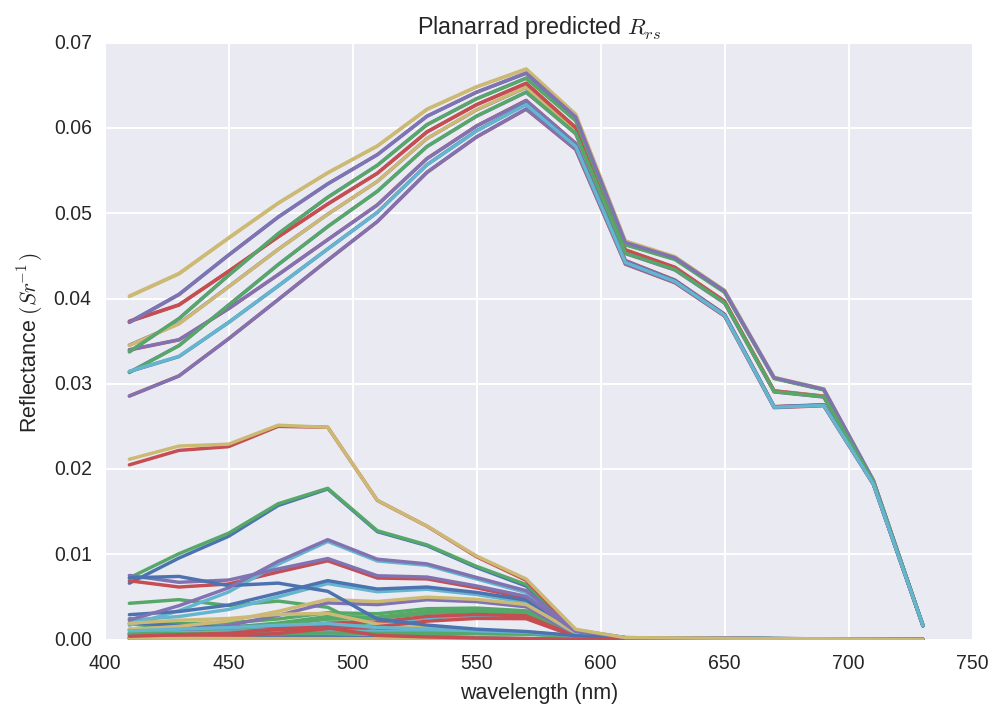

In [3]:
planar_refl = np.genfromtxt('/home/marrabld/Projects/hope_test_planarradpy/outputs/hope_test/batch_report.csv', delimiter=',', skip_header=1);
for row in planar_refl:
    plot(wavelength, row[9:]);
    
ylabel('Reflectance $(Sr^{-1})$');
xlabel('wavelength (nm)');
title(r'Planarrad predicted $R_{rs}$');

#Forward modelling with HOPE

If we use the same IOP inputs in HOPE we should get very simlar spectra returned.

HOPE is defined as:

$r_{rs}\approx r_{rs}^{dp} \left( 1 - \exp \left\{ - \left[ \frac{1}{\cos(\theta_w)} + 1.03(1 + 2.4u)^{0.5} \right] \kappa H  \right\} \right)$  
$+ \frac{1}{\pi}\rho\exp\left\{ -\left[\frac{1}{\cos(\theta_w)} + 1.04(1 + 5.4u)^{0.5} \right]\kappa H \right\}$  
where   
$r_{rs}^{dp} \approx (0.084 + 0.17u)u$  
and  
$u = \frac{b_b}{a + b_b}$, $\kappa = a + b_b$  
and  
$b_b = b_{bw} + b_{bp}$  
$a = a_w + a_\phi + a_g$

In [12]:
import numpy as np

In [4]:
class BioModel():
    def __init__(self):
        self.wavelengths = None
        self.a_phi = None
    
    def calc_a_g(self, G, S, wave_const=440.0):
        r"""
        Builds the CDOM absorption function :: :math:`G \exp (-S(\lambda - 400))`
        param: G function coefficient
        param: S slope factor
        param: wave constant
        retval null
        """
        return G * np.exp(-S * (self.wavelengths - wave_const))
    
    def calc_a_phi2(self, P):
        return P * self.a_phi
    
    def calc_a_phi(self, P):
        a0 = np.asarray([0.7782,0.9603, 0.9634, 0.8697, 0.7558, 0.6911, 0.5681, 0.4262, 0.295, 0.2595, 0.2745, 0.3421, 0.3502, 0.8435, 0.389, 0.0545, 0])
        a1 = np.asarray([0.0129, 0.002, 0.006, 0.0157, 0.0256, 0.0865, 0.0969, 0.0781, 0.06, 0.054, 0.0578, 0.0718, 0.0713, 0.1595, 0.0812, 0.0128, 0])
        
        return (a0 + a1 * np.log(P)) * P
   

        
    
    def calc_b_bp(self, X, Y, wave_const=550.0):
        r"""
        Builds the particle backscattering function  :math:`X(\frac{550}{\lambda})^Y`
        param: x function coefficient
        param: y order of the power function
        param: waveConst wave constant Default 550 nm
        retval: null
        """
        return X * (wave_const / self.wavelengths) ** Y
        

class OpticalModel(BioModel):
    """Abstract Class for the optical model"""
    def __init__(self, wavelengths):
        self.wavelengths = wavelengths
        self.a = None
        self.b = None
        self.b_b = None
        self.a_w = None
        self.b_w = None
        self.rrs = None
        self.b_bp = None
        self.a_phi = None
        self.a_g = None
        self.b_bw = None
        self.theta_w = None
        self.rho = None
        
        self.load_from_file()
        
    def load_from_file(self):
        inp_dir = '/home/marrabld/Projects/hope_test_planarradpy/inputs/'
        rho_file = inp_dir + 'bottom_files/Refl_BenthicMixture_1_17Bands.txt'
        a_phi_file = inp_dir + 'iop_files/a_phi.csv'
        a_w_file = inp_dir + 'iop_files/a_water.csv'
        b_w_file = inp_dir + 'iop_files/b_water.csv'
        
        try:
            self.rho = np.genfromtxt(rho_file, delimiter=',');
            self.a_phi = np.genfromtxt(a_phi_file, delimiter=',')[1,:];
            self.a_w = np.genfromtxt(a_w_file, delimiter=',')[1,:];
            self.b_bw = np.genfromtxt(b_w_file, delimiter=',')[1,:]; # !!CHECK THIS!!
            return 1
        except:
            return 0
        
    def forward_batch_run(self, P_list, G_list, S_list, X_list, Y_list, H_list, theta_w_list):
        rrs = np.empty_like(self.wavelengths)
        for p in P_list:
            for g in G_list:
                for s in S_list:
                    for x in X_list:
                        for y in Y_list:
                            for h in H_list:
                                for theta_w in theta_w_list:
                                    rrs = np.vstack((rrs,self.func(p, g, s, x, y, h, theta_w))) 
        return rrs
    
    def func(P, G, S, X, Y, H, theta_w):
        pass
    
class HOPE(OpticalModel):
    def __init__(self, wavelengths):
        OpticalModel.__init__(self, wavelengths)
        
    def func(self, P, G, S, X, Y, H, theta_w, g0=0.084, g1=0.17, D0=1.03, D1=2.40, D0_=1.04, D1_=5.40):
        """D0_ & D1_ are D0' and D1' in Lee, (1999)"""
        
        self.a = self.a_w + self.calc_a_phi(P) + self.calc_a_g(G, S)
        self.b_b = self.b_bw + self.calc_b_bp(X, Y)
        b_bp = self.calc_b_bp(X, Y)
        
        eta = 1.0 + 0.1 + (0.8 * b_bp / self.b_b)* sin(0.0) * sin(theta_w)
        self.b_b = self.b_bw + (eta * b_bp) 
        
        u = self.b_b / (self.a + self.b_b)
        kappa = self.a + self.b_b
        rrs_dp = (g0 + g1 * u) * u
        
        rrs_part_1 = rrs_dp * (1.0 - np.exp(-1.0 * ((1.0 / np.cos(theta_w)) + (D0 * (1.0 + D1 * u) ** 0.5 )) * kappa * H))
        rrs_part_2 = ((1.0 / np.pi) * self.rho) * np.exp(-1.0 * ((1.0 / np.cos(theta_w)) + (D0_ * (1.0 + D1_ * u)) ** 0.5) * kappa * H)
        self.rrs = rrs_part_1 + rrs_part_2   
        
        return self.rrs

#Test 1
We just choose some common values and see if the shape makes sense.  Primarily just checking for errors in the code.

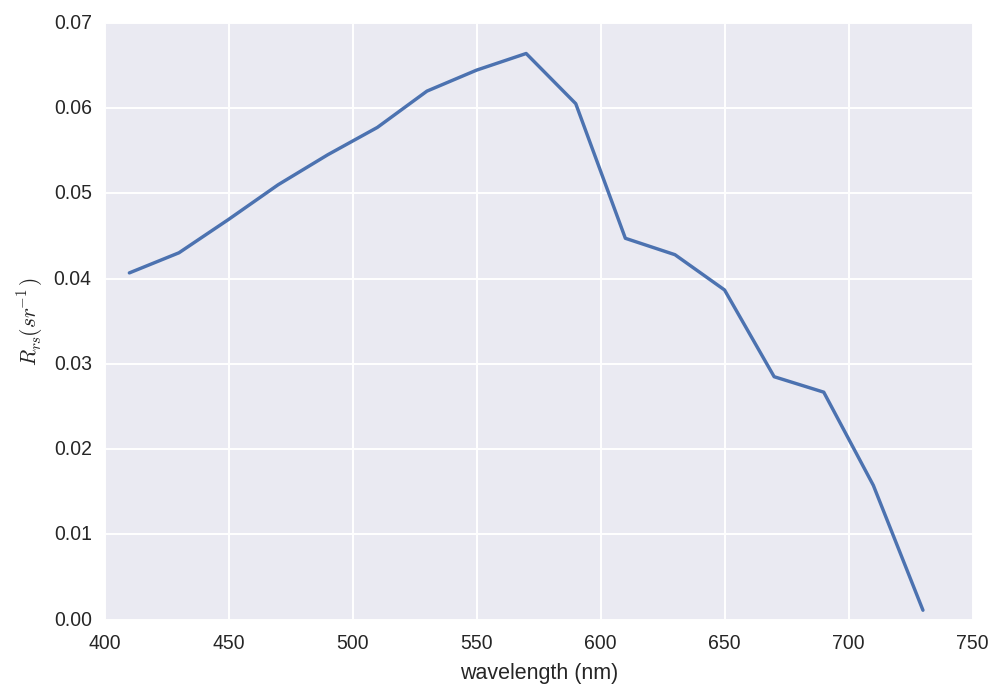

In [5]:
hope = HOPE(wavelength)
test_rrs = hope.func(0.01, 0.01, 0.015, 0.001, 1.0, 1.0, np.deg2rad(45.28))
cla()
plot(wavelength, test_rrs);
xlabel('wavelength (nm)');
ylabel('$R_{rs} (sr^{-1})$');

#Test 2
We forward batch run our parameters

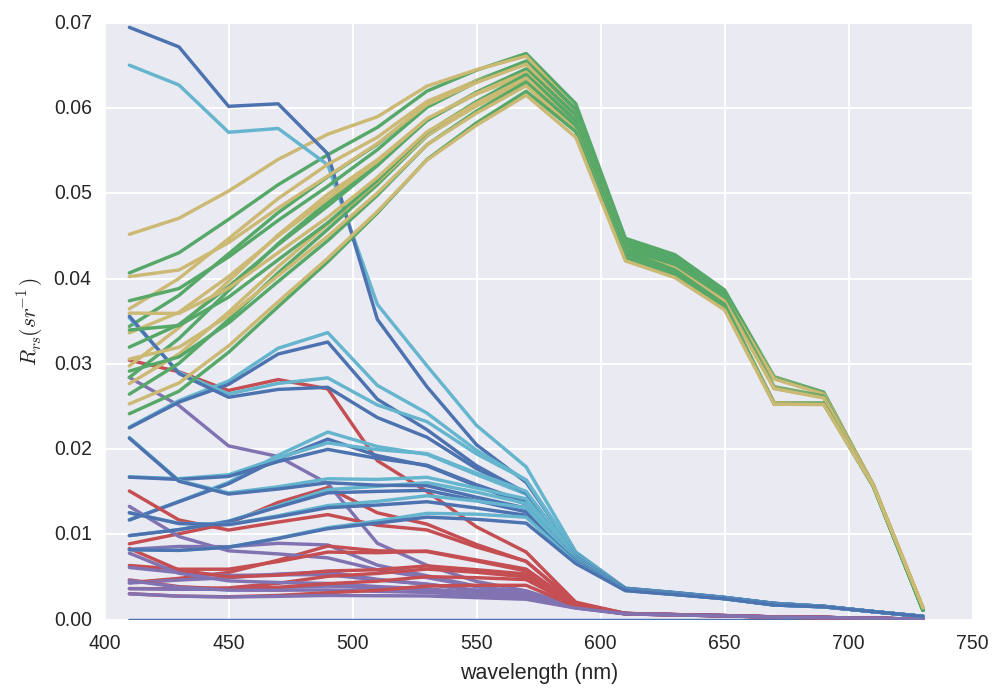

In [6]:
theta_w_list = [np.deg2rad(45.28)]
P_list = [0.01, 0.05, 0.1]
X_list = [0.001, 0.01]
Y_list = [1.0]
G_list = [0.01, 0.05, 0.1]
S_list = [0.015]
H_list = [1.0, 15.0, 50.0]

batch_rrs = hope.forward_batch_run(P_list, G_list, S_list, X_list, Y_list, H_list, theta_w_list);

for rrs_iter in batch_rrs:
    plot(wavelength, rrs_iter);
    
xlabel('wavelength (nm)');
ylabel('$R_{rs} (sr^{-1})$');

#Test 3
We compare the HOPE predicted $R_{rs}$ with the Planarrad $R_{rs}$

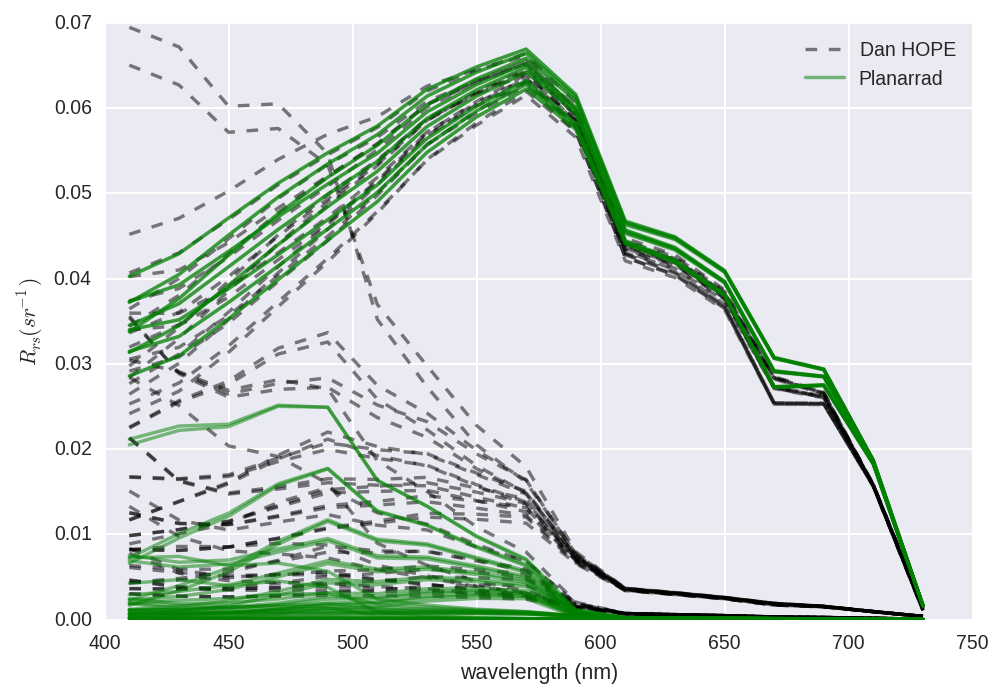

In [7]:
for i_iter, rrs_iter in enumerate(batch_rrs):
    if i_iter == 1:
        plot(wavelength, rrs_iter, '--', color='k', alpha=0.5, label='Dan HOPE');
    else:
        plot(wavelength, rrs_iter, '--', color='k', alpha=0.5);
    
for i_iter, row in enumerate(planar_refl):
    if i_iter ==1:
        plot(wavelength, row[9:], '-', color='g', alpha=0.5, label='Planarrad');
    else:
        plot(wavelength, row[9:], '-', color='g', alpha=0.5);
    
xlabel('wavelength (nm)');
ylabel('$R_{rs} (sr^{-1})$');
legend();

It is a bit of a mess but it is clear that there is no 1:1 correspondence

#Test 4
Rod independent evaluation of HOPE

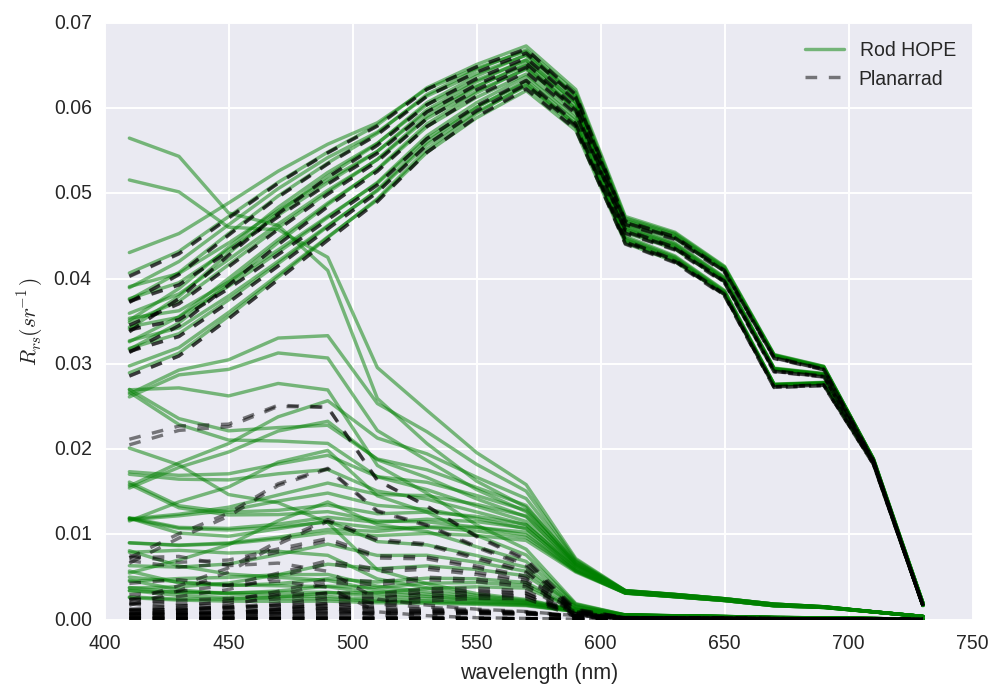

In [8]:
rod_dir = '/home/marrabld/Projects/hope_test/RodFiles/hoperesults/'
rod_rrs  = np.load(rod_dir + 'HOPE_rrs_17Bands.npy')

for i_iter, rrs_iter in enumerate(rod_rrs):
    if i_iter == 1:
        plot(wavelength, rrs_iter, '-', color='g', alpha=0.5, label='Rod HOPE');
    else:
        plot(wavelength, rrs_iter, '-', color='g', alpha=0.5);
    
for i_iter, row in enumerate(planar_refl):
    if i_iter ==1:
        plot(wavelength, row[9:], '--', color='k', alpha=0.5, label='Planarrad');
    else:
        plot(wavelength, row[9:], '--', color='k', alpha=0.5);
    
xlabel('wavelength (nm)');
ylabel('$R_{rs} (sr^{-1})$');
legend();

#Test 5
Dan's HOPE vs Rod's HOPE

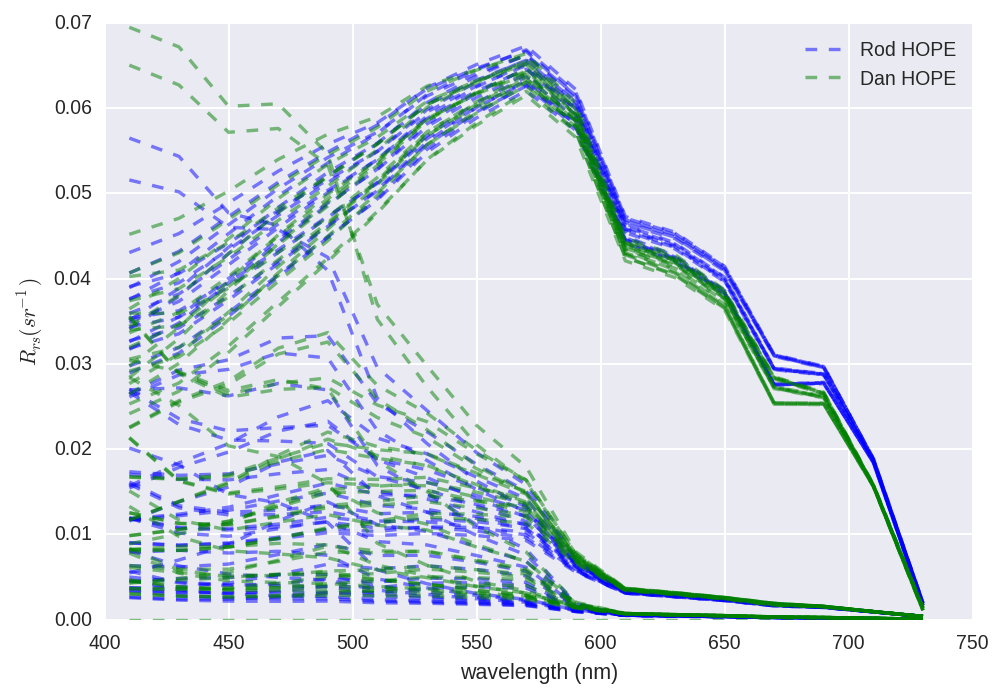

In [9]:
for i_iter, rrs_iter in enumerate(rod_rrs):
    if i_iter == 1:
        plot(wavelength, rrs_iter, '--', color='b', alpha=0.5, label='Rod HOPE');
    else:
        plot(wavelength, rrs_iter, '--', color='b', alpha=0.5);
    
for i_iter, row in enumerate(batch_rrs):
    if i_iter == 1:
        plot(wavelength, row, '--', color='g', alpha=0.5, label='Dan HOPE');
    else:
        plot(wavelength, row, '--', color='g', alpha=0.5);
    
xlabel('wavelength (nm)');
ylabel('$R_{rs} (sr^{-1})$');
legend();

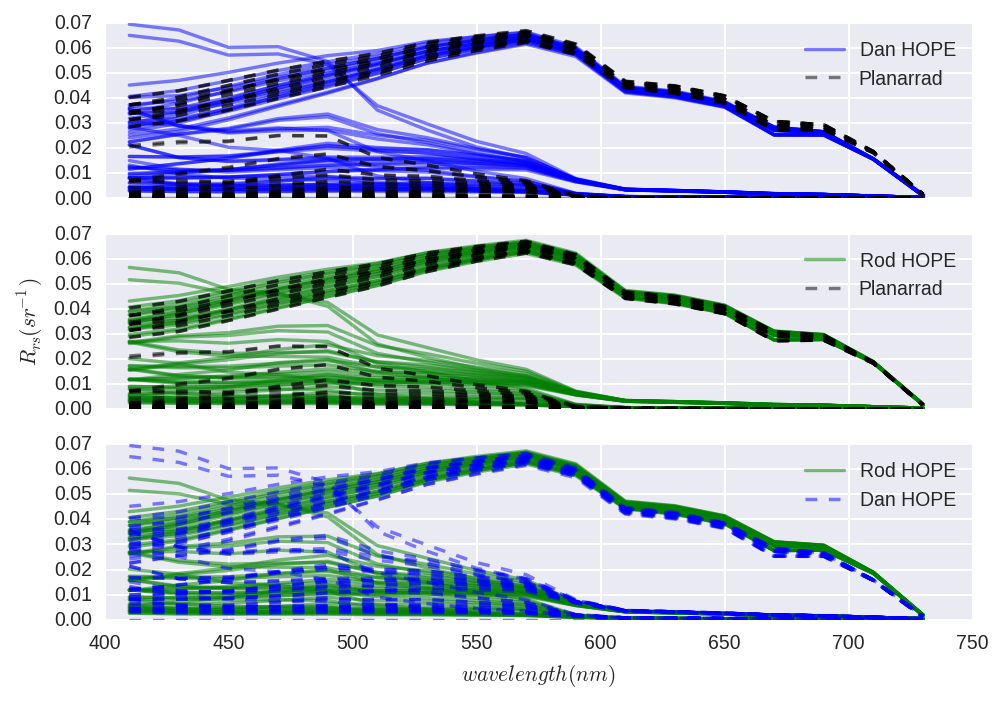

In [10]:
ax1 = subplot(3,1,1)
for i_iter, rrs_iter in enumerate(batch_rrs):
    if i_iter == 1:
        plot(wavelength, rrs_iter, '-', color='b', alpha=0.5, label='Dan HOPE');
    else:
        plot(wavelength, rrs_iter, '-', color='b', alpha=0.5);
    
for i_iter, row in enumerate(planar_refl):
    if i_iter ==1:
        plot(wavelength, row[9:], '--', color='k', alpha=0.5, label='Planarrad');
    else:
        plot(wavelength, row[9:], '--', color='k', alpha=0.5);
        
setp( ax1.get_xticklabels(), visible=False)
    
#xlabel('wavelength (nm)');
#ylabel('$R_{rs} (sr^{-1})$');
legend();

ax2 = subplot(3,1,2, sharex=ax1)

for i_iter, rrs_iter in enumerate(rod_rrs):
    if i_iter == 1:
        plot(wavelength, rrs_iter, '-', color='g', alpha=0.5, label='Rod HOPE');
    else:
        plot(wavelength, rrs_iter, '-', color='g', alpha=0.5);
    
for i_iter, row in enumerate(planar_refl):
    if i_iter ==1:
        plot(wavelength, row[9:], '--', color='k', alpha=0.5, label='Planarrad');
    else:
        plot(wavelength, row[9:], '--', color='k', alpha=0.5);
        
setp( ax2.get_xticklabels(), visible=False)
    
#xlabel('wavelength (nm)');
ylabel('$R_{rs} (sr^{-1})$');
legend();

ax3 = subplot(3,1,3, sharex=ax1)
for i_iter, rrs_iter in enumerate(rod_rrs):
    if i_iter == 1:
        plot(wavelength, rrs_iter, '-', color='g', alpha=0.5, label='Rod HOPE');
    else:
        plot(wavelength, rrs_iter, '-', color='g', alpha=0.5);
    
for i_iter, row in enumerate(batch_rrs):
    if i_iter == 1:
        plot(wavelength, row, '--', color='b', alpha=0.5, label='Dan HOPE');
    else:
        plot(wavelength, row, '--', color='b', alpha=0.5);
    
xlabel('$wavelength (nm)$');
#ylabel('$R_{rs} (sr^{-1})$');
legend();